In [52]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [53]:
train_path = "../data/raw/spider_classification/train"
val_path = "../data/raw/spider_classification/valid"

In [54]:
# Image dimensions and batch size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
NUM_CLASSES = 15

In [55]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

In [56]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [57]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 2185 images belonging to 15 classes.


In [58]:
val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 75 images belonging to 15 classes.


In [59]:
# =====================
# Compute Class Weights
# =====================
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

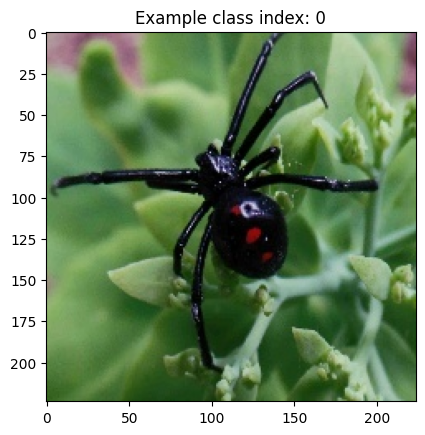

In [60]:
x_batch, y_batch = next(train_generator)
plt.imshow(x_batch[0])
plt.title(f"Example class index: {np.argmax(y_batch[0])}")
plt.show()


In [61]:
# =====================
# Model Architecture
# =====================
model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(512, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(NUM_CLASSES, activation='softmax')
])

In [62]:
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [63]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [64]:
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [65]:
# =====================
# Train Model
# =====================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)

Epoch 1/50


C:\Users\Owner\PycharmProjects\tarantula-species-image-classifier\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1454 - loss: 5.5553
Epoch 1: val_accuracy improved from -inf to 0.08000, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.1466 - loss: 5.5115 - val_accuracy: 0.0800 - val_loss: 4.7467
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2889 - loss: 2.0933
Epoch 2: val_accuracy did not improve from 0.08000
35/35 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.2898 - loss: 2.0922 - val_accuracy: 0.0667 - val_loss: 9.3212
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3597 - loss: 1.9360
Epoch 3: val_accuracy did not improve from 0.08000
35/35 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.3598 - loss: 1.9354 - val_accuracy: 0.0667 - val_loss: 12.4318
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4425 - loss: 1.7020
Epoch 4: val_accuracy did not improve from 0.08000
35/35 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4424 - loss: 1.7022 - val_accuracy: 0.066

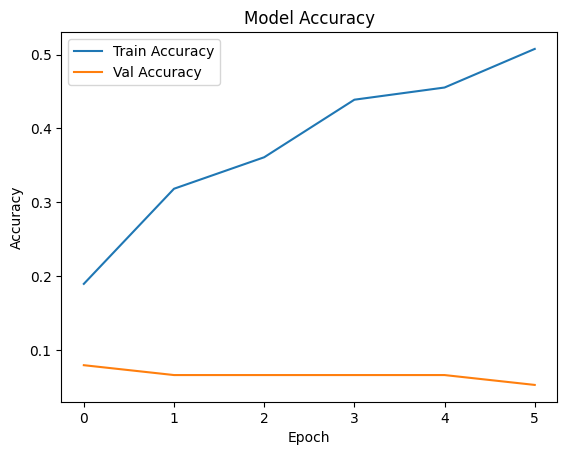

In [66]:
# =====================
# Plot Performance
# =====================
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

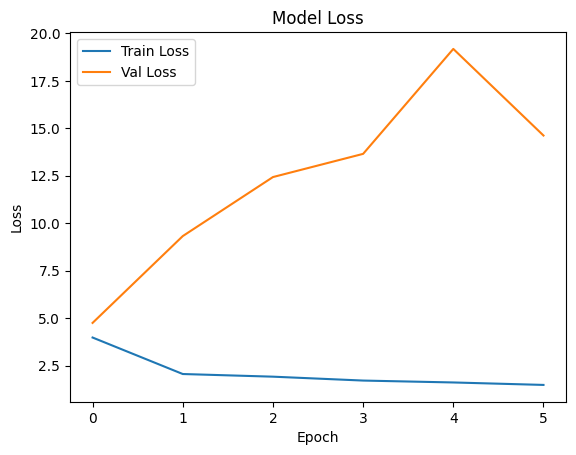

In [67]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [68]:
print("\nEvaluating best model on validation data...")
best_model = load_model("best_model.keras")
val_preds = best_model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes
labels = list(val_generator.class_indices.keys())


Evaluating best model on validation data...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


In [69]:
# Get predictions on validation set
val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)           # predicted class indices
y_true = val_generator.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


In [70]:
# Get class labels
labels = list(val_generator.class_indices.keys())

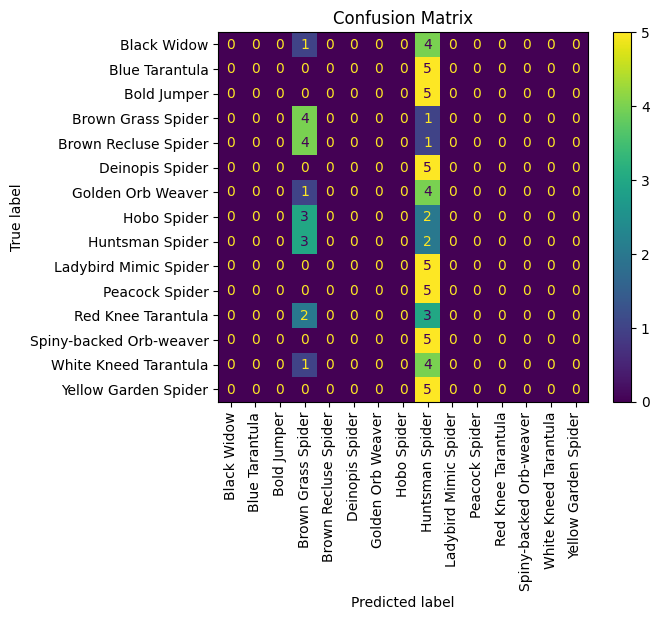

In [71]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

In [72]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

Classification Report:
                         precision    recall  f1-score   support

            Black Widow       0.00      0.00      0.00         5
         Blue Tarantula       0.00      0.00      0.00         5
            Bold Jumper       0.00      0.00      0.00         5
     Brown Grass Spider       0.21      0.80      0.33         5
   Brown Recluse Spider       0.00      0.00      0.00         5
        Deinopis Spider       0.00      0.00      0.00         5
      Golden Orb Weaver       0.00      0.00      0.00         5
            Hobo Spider       0.00      0.00      0.00         5
        Huntsman Spider       0.04      0.40      0.07         5
  Ladybird Mimic Spider       0.00      0.00      0.00         5
         Peacock Spider       0.00      0.00      0.00         5
     Red Knee Tarantula       0.00      0.00      0.00         5
Spiny-backed Orb-weaver       0.00      0.00      0.00         5
  White Kneed Tarantula       0.00      0.00      0.00         5
 

In [73]:
import numpy as np
print("Classes predicted:", np.unique(y_pred))
print("Classes in validation set:", np.unique(y_true))

Classes predicted: [3 8]
Classes in validation set: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [74]:
import collections
print("Predicted class distribution:")
print(collections.Counter(y_pred))

Predicted class distribution:
Counter({np.int64(8): 56, np.int64(3): 19})


In [75]:
import collections
print(collections.Counter(train_generator.classes))

Counter({np.int32(2): 189, np.int32(14): 177, np.int32(8): 168, np.int32(1): 160, np.int32(10): 157, np.int32(12): 154, np.int32(6): 153, np.int32(7): 152, np.int32(4): 140, np.int32(3): 136, np.int32(11): 127, np.int32(13): 126, np.int32(0): 122, np.int32(5): 120, np.int32(9): 104})


In [76]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 10, 10, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 24,399,087 (93.08 MB)

 Trainable params: 8,132,367 (31.02 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 16,264,736 (62.05 MB)

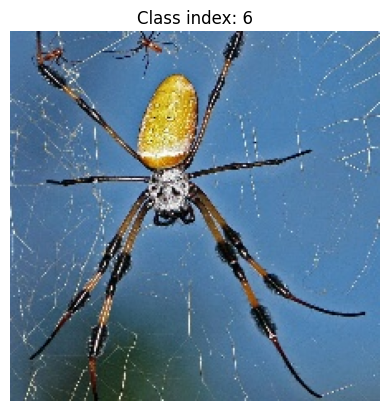

In [77]:
x_batch, y_batch = next(train_generator)

import matplotlib.pyplot as plt
plt.imshow(x_batch[0])  # Check image appearance
plt.title(f"Class index: {np.argmax(y_batch[0])}")
plt.axis("off")
plt.show()

In [78]:
small_train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

model.fit(small_train_generator, steps_per_epoch=1, epochs=10)

Found 2185 images belonging to 15 classes.
Epoch 1/10


C:\Users\Owner\PycharmProjects\tarantula-species-image-classifier\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4375 - loss: 2.0084
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step - accuracy: 0.3438 - loss: 2.1423
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step - accuracy: 0.2188 - loss: 2.2249
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step - accuracy: 0.3750 - loss: 2.3265
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step - accuracy: 0.3750 - loss: 1.9985
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step - accuracy: 0.5000 - loss: 1.8247
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step - accuracy: 0.4375 - loss: 2.2492
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step - accuracy: 0.3438 - loss: 1.7416
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step - accuracy: 0.3438 - loss: 2.4380
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step - accuracy: 0.3438 - loss: 2.2633


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


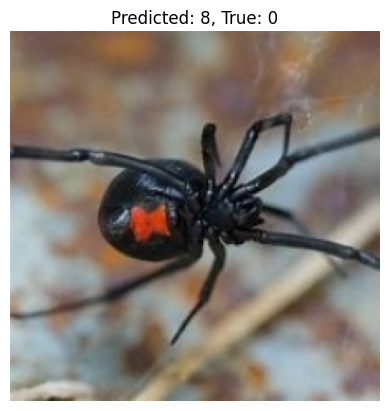

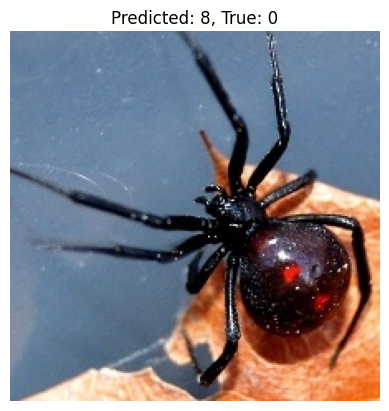

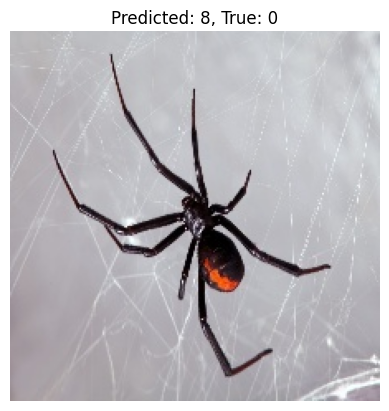

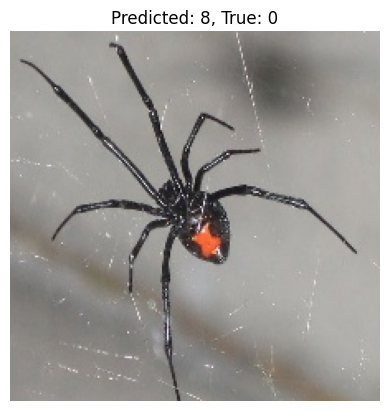

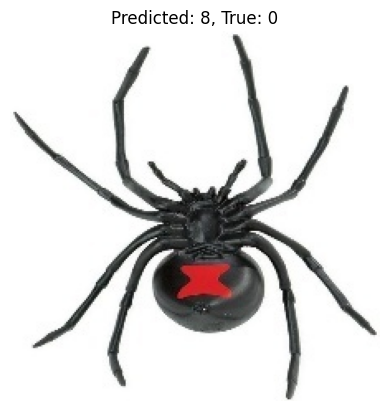

In [79]:
x, y = next(val_generator)
preds = model.predict(x)
for i in range(5):
    plt.imshow(x[i])
    plt.title(f"Predicted: {np.argmax(preds[i])}, True: {np.argmax(y[i])}")
    plt.axis("off")
    plt.show()